In [1]:
import itertools
import numpy as np
import math
from matplotlib import pyplot as plt
import random

# Physical constants for experiment

In [2]:
ev_c2 = 1.783e-36   # eV/c^2 in units of kg
me_kg   = 9.1e-31   # mass of e- [kg]
me = me_kg/ev_c2    # mass of e- [eV/c^2]
c = 3e8             # speed of light [m/s]

v = np.sqrt(1-(510/(60+510))**2) # speed of e- w.r.t c i.e., gamma factor
print('(non)relativistic electron velocity(/c) is ' +str(v) + ' (' + str(np.sqrt(2*60/510)) + ')')      # v vs. non-relativistic calculation for velocity

h = 4.135e-15       # plank's constant [eV]  (not h-bar, just h)
l_NV = 575          # nv wavelength [nm]
f_NV = c*1e9/l_NV   # frequency (conversion nm <--> m)
E_NV = h * f_NV     # energy [eV]
E_660 = h * (c*1e9/660)
E_610 = h * (c*1e9/610)
DE = E_NV - E_660   # energy lost to plasmon [eV]
print('energy lost to plasmon around ' + str(DE) + ' eV')


q = 1.602e-19       # electron charge [C]
I0 = q/1e-9 * 1e9   # current for 1 e- per ns [nA]
print('current for 1e- per 1 nanosecond is ' + str(I0) + ' nA')


(non)relativistic electron velocity(/c) is 0.446593756539 (0.485071250073)
energy lost to plasmon around 0.27784584980237126 eV
current for 1e- per 1 nanosecond is 0.1602 nA


# Monte Carlo Simulation Cathodoluminescence 
Following Meuret, Kociak, et. al., PRL & supplemental material. 


We outline the experimental and some material parameters taken from the literature which are allow our caculations to be realistic with respect to materials properties. 

#### Energy-scales
The electrons are accelerated with $60 keV$ potential. At this energy scale the electrons move at a veloctity $v = .44 * c$ 

1. Plasmon modes should be $\mathcal{O}(10 eV)$ excitations. This correlates well with the big EELS peak around 40 eV in Kociak's supplemental material. 
2. Electron-hole exicton pairs are of $E_{eh} = 5 eV$ as per the band-gap in diamond
3. NV$^0$ centers with $2.156 eV$ (575nm) energy gap between a doublet $^2E$ states and $^2A$ states. The NV gap isembedded within the semiconductor band-gap. 
4. There exist phonon bands with much lower energies than all the modes listed above. Photons exhibiting maximal bunching lie between 610-665 nm and this corresponds to a loss of $\sim .25eV$



#### Timescales

The e-beam current depends on the extraction voltage which removes electrons.In the Kociak paper the currents range between $1pA$-$100pA$ while the ORNL experiment uses currents betwee $100 pA$ to $10 nA$. 

0. Bunching bandwidth of $\sim 100ns$ for 610 nm and 665 nm filtered data.
1. NV decay timescales seems to be on the order of $\mathcal{O}(10ns)$. 


#### Other physical constraints 

0. Following Kociak in the supplemental material section 6 the average plasmon creation number should be taken around ~2 
1. The interaction probability is defined as $P_{INT} \equiv 1 - \exp \left\{ - l_d \sigma \rho \right\}$]
   * The NV density is ~ 1200 NV color centers / nanocrystal. Since each nanocrystal is ~ $100 nm^3$ that comes to a rough density of $\rho = 1.2 *10^{-3} \frac{NV}{nm^3}$ or $\approx 1 \frac{NV}{(10nm)^3}$


## Time series simulation 
The time series simulation is performed in two different ways below 

1. We discretizing time into timesteps dt and at each either select an electron arrival or do not. 
   * Likewise, for NV's which are excited, they are allowed to probablistically decay at each timestep.. 
    
B. Following Kociak again, we stochastically pick electron arrivals times. 
   * These arrival time shall be the excitation times for the (possibly many) NV's which are stimulated within a very short (ps) time window. 
   * We also stochastically choose NV radiation times 


# Poissonian time series simulation

We simulate the experimenal data using a simple monte carlo simulation. 
In our numerics we build a probability function $t_{em}$ as matrix consiting of radiation times.
The radiation times are taken to depend on the electron beam current and on the nano-crystal-NV physics. 

$$ t^{ij}_{em} $$

1. Given a constant current, the average arrival time $\Delta t$ between electrons in the e-beam is $\Delta t = I/q_e$ where $I$ is the beam current and $q_e = 1.602*10^{-19}C$ is the electron charge. Generating the inter-electron times $\Delta i$'s from a Poissonian distribution is performed by the emn_arrivals function. Define the global arrival times recursively $t_n = \Delta_n + t_{n-1}$ to consider the set $\{ t_1, ... t_N\}$. $$ $$ The $\Delta i$'s are sampled as follows. Conider the poisson probabilty distibution $P(k,\lambda) = {\displaystyle {\frac {\lambda ^{k}e^{-\lambda }}{k!}}}$. The probablity of for the $k=0$ event for $m$ consecutive samples is $P(0,\lambda)^m = e^{-m \lambda}$. This exponential decay distribution and electron times are thus simulated by taking $\Delta_i = - t_m \ln(1-r_i)$ where each $r_i$ is a random number evenly distributed along the interval $\left[0,1\right]$. This collection of $\{ \Delta_i \}$ and the interaction times ($\{ t_1, ... t_N\}$) constitute the first poissonian simulated data.


2. At each $t_i$ the electron activates a number of microscipic modes  associated with the Nano-diamond samples. Since we count the emissions originating from the NV color centers, we construct an simple effective model to treat the internal dynamics. Due to the broad nature of the electron beam exictations, many modes (plasmons, phonons, e-h excitions, and NVs) are excited at each electron arrival time $t_i$. A simple model considering the activation of NV's through plasmonic, and exiton pathways was considered earlier \cite{Meuret}. 


 At each of these times  are excited. Eventually the excited NV's radiate at some later time. The radiation times are output by the radiation times function
 generates a series of times at from which NV centers may emit


3. Finally we post-proccess the radiation times into a histogram style g2 correlation function

In [ ]:
def em_arrrivals(mean_time, number = 1000):
    """
    Simulate the arrival times of e- particles
    according to a poission distribution given 
    
    Parameters
    ----------
    mean_time: the poissonian mean time (i.e. lambda parameter)
    number: the number of times to simulate
    
    Retruns
    -------
    delta_ts: delays between electrons
    times:    times of electron arrivals
    """
    delta_ts = [- mean_time *  np.log(1-random.random()) for i in range(number)]
    times = [0] * number

    for i,t in enumerate(delta_ts):
        if i == 0:
            times[i] = delta_ts[i]
        else:
            times[i] = times[i-1] + delta_ts[i]
    return delta_ts, times

def radiation_times(times, N_NV, t_r):
    """
    Simulate the radaition times of an unbounded collection of NV's
    
    Parameters
    ----------
    times: discretized times at which NV's may be excited
    N_NV: average number of NV's excited per e-
    t_r : mean NV relaxation/radiation timescale
    
    Returns
    -------
    rad_times: sorted list of times at which a radiation event occurs
    
    """
    
#   for k in range(number):                         # count number of NV excitations accompanying each electron    
#         npl = 5                                   # number of plasmon modes populated according to p_pl_cdf
#         for i in range(npl):
#             for j in range(neh):
#                 if random.random() < p_INT:
#                     nv_arrivals[k] += 1 
                
    nv_arrivals = [0] * len(times)    
    nv_arrivals = np.random.poisson(N_NV, len(times)) 
    
    rad_times = []                                 # simulate the radiation times series data
    for k in range(len(times)):
        for j in range(nv_arrivals[k]):
            rad_times.append(times[k] - t_r * np.log(1-random.random()))

    rad_times.sort()
    
    return  rad_times



def delays(rad_times, tau_max):
    """
    Calculate delays 'between each photon and all the others' 
    within a time window of width tau_max. This way we may
    reconstruct the g2 correlation function
    in the "histogram mode" used to experimentally determine $g^{(2)}$. 
    The histogramming corresponds to the convolution of 
    two functions in some discrete time specificed by the bin width

    Parameters
    ----------
    rad_times: a list of ordered radiation times 
    tau_max: time window, e.g. of 100 ns, for duration of coincedence counting
    
    Returns:
    --------
    delay times: w/o self delay at \tau = 0.0
    """
    t_s = [t for t in rad_times if t > min(rad_times) + tau_max and t < max(rad_times) - tau_max ]

    delay_times = []
    for t1 in t_s:
        
        i = rad_times.index(t1)
        j = i + 1
        k = i - 1
        
        while abs(rad_times[j] - t1) < tau_max:
            delay_times.append(rad_times[j]-t1)
            j += 1

        while abs(rad_times[k] - t1) < tau_max:
            delay_times.append(rad_times[k]-t1)
            k -= 1
            
    return  delay_times


def binning():
    """
    Bins the relative delays as per 'histogram mode'
    
    Parameters:
    -----------
    delays: Array of delay times -- output from delay times function
    
    Returns:
    --------
    bins:   Array of bin centers
    hists:  Array of histgram counts
    """
    

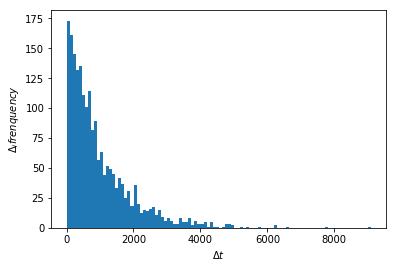

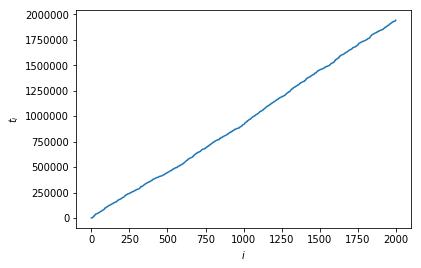

number of radiation events is 2014


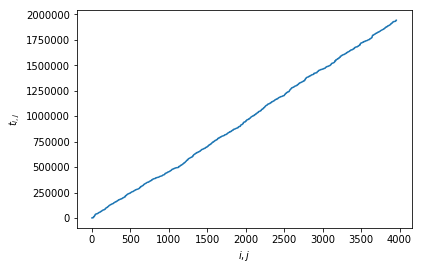

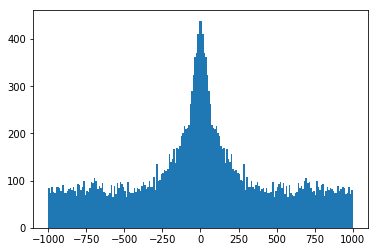

In [159]:
tm = 1e3         # electron mean arrival time [ps]
N = int(2e3)     # number of electron events
f = 2            # mean ratio of NV's to e-'s 
t_r = 1e2        # NV radiation timescale [ps]    
n_bins = 500 
tau_max = 1000


arrival_times = em_arrrivals(mean_time=tm , number=N)

plt.hist(arrival_times[0], bins = 100)
plt.xlabel('$\Delta t$')
plt.ylabel('$\Delta_i frenquency$')

plt.show()
plt.plot(arrival_times[1])
plt.xlabel('$i $')
plt.ylabel('$t_i $')
plt.show()

r_tms = radiation_times(arrival_times[1], f, t_r)
print('number of radiation events is ' + str(len(rad_mat)))
plt.plot(r_tms)
plt.xlabel('$i,j $')
plt.ylabel('$t_{i,j} $')
plt.show()



plt.hist(delays(r_tms, 1000), bins=200)
plt.show()

In [201]:
np.random.poisson(2, 100)


array([1, 2, 1, 1, 2, 3, 2, 6, 2, 0, 5, 1, 0, 2, 2, 1, 2, 3, 1, 2, 4, 4, 0,
       1, 1, 2, 4, 1, 1, 1, 2, 3, 1, 1, 2, 1, 3, 2, 2, 3, 3, 4, 0, 2, 3, 1,
       1, 3, 1, 2, 1, 4, 1, 2, 1, 2, 4, 0, 0, 3, 3, 3, 1, 1, 2, 3, 2, 2, 3,
       3, 3, 1, 2, 2, 0, 6, 2, 4, 5, 1, 0, 1, 1, 3, 2, 2, 4, 1, 3, 1, 1, 7,
       3, 1, 5, 2, 5, 1, 1, 5])

In [202]:
radiation_times(at, 2, t_r)

[405.2322731611257,
 443.81296351925971,
 471.33101327615452,
 898.54295265279347,
 932.85042214645364,
 966.45039244624604,
 983.97392636972654,
 1009.8741053794865,
 1035.6945782221981,
 1047.1595615005228,
 2690.5463910238586,
 2746.3156296173202,
 2782.8747526872744,
 2881.1860385677883,
 3118.4376489132583,
 4394.9791051880993,
 4900.6308895610482,
 4953.0928585387328,
 7060.1006864038764,
 10571.923214634051,
 11214.151193185651,
 11423.715945604887,
 12048.579996287963,
 12082.389995769923,
 12386.692442710668,
 12386.999369747577,
 12427.610532251085,
 12451.591620874611,
 12494.750578188927,
 12552.746196580954,
 13143.582366204884,
 13968.564487319805,
 13968.717965887237,
 13978.50663347935,
 13979.147098757285,
 14079.761589239821,
 14486.832127605563,
 14561.168696461842,
 15048.390395561637,
 15091.287646562059,
 15138.723338491303,
 15303.834677609449,
 15414.345637518029,
 15471.441381083639,
 15475.8486225916,
 15497.793415214313,
 15505.482189953689,
 15525.6123868054

In [192]:
arrival_times1 = em_arrrivals(mean_time=5*tm , number=N)
arrival_times2 = em_arrrivals(mean_time=1/5*tm , number=N)

r_tms1 = radiation_times(arrival_times1[1], f, t_r)
r_tms2 = radiation_times(arrival_times2[1], f, t_r)

# plt.hist(arrival_times1[0], bins = 100)
# plt.xlabel('$\Delta t$')
# plt.ylabel('$\Delta_i frenquency$')
# plt.show()

# plt.hist(arrival_times2[0], bins = 100)
# plt.xlabel('$\Delta t$')
# plt.ylabel('$\Delta_i frenquency$')
# plt.show()

plt.hist(delays(r_tms1, 1000), bins=200)
plt.show()
plt.hist(delays(r_tms2, 1000), bins=200)
plt.show()


TypeError: float() argument must be a string or a number, not 'Figure'

### Current dependence

1.0 is done
5.0 is done
10.0 is done
50.0 is done
100.0 is done


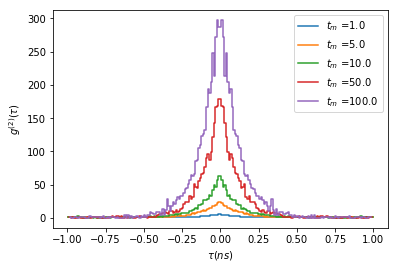

In [215]:
N = int(2e3)     # number of electron events
f = 2            # mean ratio of NV's to e-'s 
t_r = 1e2        # NV radiation timescale [ps]    
n_bins = 500 
tau_max = 1000
N_NV = 2

mean_times  = [1e3, 5e3, 1e4, 5e4, 1e5]

n_bins = 200
f, ax = plt.subplots(1, sharex=True)
for tm in mean_times:
    at = em_arrrivals(mean_time= tm, number=N)[1] # arrival times
    rt = radiation_times(at, N_NV, t_r)
    d = delays(rt, 1000)

    # look through delays at different currents 

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers/1000                                  # Plot with [ns] time units
    print(str(tm/1000) + 'ns mean arrival time')
    plt.step(bins, hists, label = str(tm/1000))
    
plt.xlabel('$\\tau (ns)$')
plt.ylabel('$g^{(2)}(\\tau)$')
plt.legend(['$t_m$ =' + str(m/1000) for m in mean_times])
plt.show()

### NV factor dependence

For a low NV/e- ratio $N_{NV} \in (0.1,5)$ the $g^{(2)}$ is constant.

5.0 is done
16.25 is done
27.5 is done
38.75 is done
50.0 is done


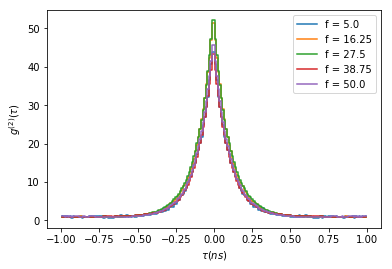

In [222]:
tm = 1e4         # electron mean arrival time [ps]
N = int(2e3)     # number of electron events
f = 2            # mean ratio of NV's to e-'s 
t_r = 1e2        # NV radiation timescale [ps]    
n_bins = 500 
tau_max = 1000
n_bins = 200


N_NV_range = np.linspace(5,50,5)
f, ax = plt.subplots(1, sharex=True)
for N_NV in N_NV_range:
    at = em_arrrivals(mean_time= tm, number=N)[1] # arrival times
    rt = radiation_times(at, N_NV, t_r)
    d = delays(rt, 1000)

    # look through delays at different currents 

    hist, bin_edges = np.histogram(d, bins=n_bins)           # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins = bin_centers/1000                                  # Plot with [ns] time units
    print(str(N_NV) + ' is done')                            # simulation length increases with N_NV
    plt.step(bins, hists, label = 'f = ' + str(N_NV))
    
plt.xlabel('$\\tau (ns)$')
plt.ylabel('$g^{(2)}(\\tau)$')
plt.legend()
plt.show()

### Radiation lifetimes and phonon scattering


We explore the effect that the NV radiation rate has on the $g^{(2)}(\tau)$ properties. 